In [1]:
import h5py
import numpy as np
import os
import cv2
from pathlib import Path
import random

# Example paths (adjust as needed)
# angiographyDataFile = "/path/to/your/angiography.h5"
# nnUNetRawFolder = "/path/to/nnUNet/raw/folder"
angiographyDataFile = "/home/ubuntu/Angiostore/WebknossosAngiogramsRevisedUInt8List.h5"
# Can assume already indicized
# annotationDataFile = "/home/ubuntu/Angiostore/WebknossosAnnotationsRevisedUnitized-5.h5"
annotationIndicizedDataFile = "/home/ubuntu/Angiostore/WebknossosAnnotationsRevisedIndicized-3.h5"
nnUNetRawFolder = "/home/ubuntu/nnUNet-Adjustment/data/nnUNet_raw/Dataset632_Angiography"

In [2]:
def get_common_keys(angiographyDataFile, annotationDataFile):
    """
    Get the intersection of keys between the two HDF5 files
    """
    with h5py.File(angiographyDataFile, 'r') as f_angio, \
         h5py.File(annotationDataFile, 'r') as f_anno:
        
        angio_keys = set(f_angio.keys())
        anno_keys = set(f_anno.keys())
        common_keys = sorted(list(angio_keys.intersection(anno_keys)))
        
        print(f"Angiography keys: {len(angio_keys)}")
        print(f"Annotation keys: {len(anno_keys)}")
        print(f"Common keys: {len(common_keys)}")
        
        return common_keys


In [3]:
# Get common keys first
common_keys = get_common_keys(angiographyDataFile, annotationIndicizedDataFile)

# If you want to see the keys before proceeding
print("Common keys:", common_keys)

Angiography keys: 160
Annotation keys: 129
Common keys: 129
Common keys: ['01_Case_CSF8U1R1_14', '01_Case_CSF8U1RQ_13', '03_Case_CSF8UKA1_2', '03_Case_CSF8UKA5_4', '03_Case_CSF8UKA9_1', '03_Case_CSF8UKAH_5', '06_Case_CSF8W343_9', '10_Case_CSF8WNXU_5', '10_Case_CSF8WNY6_1', '12_Case_CSF8XAD2_23', '12_Case_CSF8XADW_10', '13_Case_CSVS1XAP_1', '13_Case_CSVS1XAU_6', '13_Case_CSVS1XB4_2', '14_Case_CSVS23F6_14', '14_Case_CSVS23FO_5', '14_Case_CSVS23FS_4', 'Angios_005_rev', 'Angios_006_rev', 'Angios_007_rev', 'Angios_013_rev', 'Angios_015_rev', 'Angios_016_rev', 'Angios_021_rev', 'Angios_022_rev', 'Angios_030_rev', 'Angios_031_rev', 'Angios_032_rev', 'Angios_048_rev', 'Angios_061_rev', 'Angios_063_rev', 'Angios_065_rev', 'Angios_067_rev', 'Angios_072_rev', 'Angios_075_rev', 'Angios_079_rev', 'Angios_081_rev', 'Angios_082_rev', 'Angios_104_rev', 'Angios_114_rev', 'Angios_120_rev', 'Angios_128_rev', 'Angios_129_rev', 'Angios_133_rev', 'Angios_148_rev', 'Angios_157_rev', 'Angios_161_rev', 'Angios

In [4]:

def export_angiography_to_nnunet(angiographyDataFile, nnUNetRawFolder, common_keys):
    """
    Modified to only process common keys and handle 7.5 Hz data by selecting every other frame.
    For 7.5 Hz data, we select every other frame while maintaining the 5-frame neighborhood structure.
    We process all frames (both even and odd center indices) to maximize training data.
    """
    images_dir = os.path.join(nnUNetRawFolder, 'imagesTr')
    Path(images_dir).mkdir(parents=True, exist_ok=True)
    
    frameKeys=[]
    
    with h5py.File(angiographyDataFile, 'r') as f:
        blockCounter = 0
        
        # Only iterate through common keys
        for dataset_name in common_keys:
            print(f"Processing angiogram dataset: {dataset_name}")
            angio_data = f[dataset_name][:]
            
            n_frames = angio_data.shape[0]
            
            # Process all frames with step 1
            for center_idx in range(4, n_frames - 4, 1):  # Step by 1 to process all frames
                frameKeys.append([dataset_name, center_idx])
                # Get frame indices with step of 2 to maintain 5-frame neighborhood
                frame_indices = [center_idx - 4, center_idx - 2, center_idx, center_idx + 2, center_idx + 4]
                frames = angio_data[frame_indices]
                
                for frame_num, frame in enumerate(frames):
                    if frame.dtype != np.uint8:
                        if frame.max() > 1:
                            frame = (frame / frame.max() * 255).astype(np.uint8)
                        else:
                            frame = (frame * 255).astype(np.uint8)
                    
                    filename = f'Angios_{blockCounter:04d}_{frame_num:04d}.png'
                    filepath = os.path.join(images_dir, filename)
                    cv2.imwrite(filepath, frame)
                
                blockCounter += 1
        
        print(f"Exported {blockCounter} sets of 5 frames each")
        print(f"Total number of PNG files created: {blockCounter * 5}")
        return frameKeys

In [5]:
frameKeys = export_angiography_to_nnunet(angiographyDataFile, nnUNetRawFolder, common_keys)


Processing angiogram dataset: 01_Case_CSF8U1R1_14
Processing angiogram dataset: 01_Case_CSF8U1RQ_13
Processing angiogram dataset: 03_Case_CSF8UKA1_2
Processing angiogram dataset: 03_Case_CSF8UKA5_4
Processing angiogram dataset: 03_Case_CSF8UKA9_1
Processing angiogram dataset: 03_Case_CSF8UKAH_5
Processing angiogram dataset: 06_Case_CSF8W343_9
Processing angiogram dataset: 10_Case_CSF8WNXU_5
Processing angiogram dataset: 10_Case_CSF8WNY6_1
Processing angiogram dataset: 12_Case_CSF8XAD2_23
Processing angiogram dataset: 12_Case_CSF8XADW_10
Processing angiogram dataset: 13_Case_CSVS1XAP_1
Processing angiogram dataset: 13_Case_CSVS1XAU_6
Processing angiogram dataset: 13_Case_CSVS1XB4_2
Processing angiogram dataset: 14_Case_CSVS23F6_14
Processing angiogram dataset: 14_Case_CSVS23FO_5
Processing angiogram dataset: 14_Case_CSVS23FS_4
Processing angiogram dataset: Angios_005_rev
Processing angiogram dataset: Angios_006_rev
Processing angiogram dataset: Angios_007_rev
Processing angiogram datase

In [6]:
def get_hdf5_keys(hdf5_file: str) -> list[str]:
    """
    Get list of dataset keys in an HDF5 file.

    Args:
        hdf5_file: Path to the HDF5 file

    Returns:
        list[str]: List of dataset keys in the file
    """
    with h5py.File(hdf5_file, 'r') as f:
        keys = list(f.keys())
        print(f"Keys in {hdf5_file}:")
        for key in keys:
            print(f"  {key}")
        return keys

# Get keys from annotationIndicizedDataFile
keys = get_hdf5_keys(annotationIndicizedDataFile)


Keys in /home/ubuntu/Angiostore/WebknossosAnnotationsRevisedIndicized-3.h5:
  01_Case_CSF8U1R1_14
  01_Case_CSF8U1RQ_13
  03_Case_CSF8UKA1_2
  03_Case_CSF8UKA5_4
  03_Case_CSF8UKA9_1
  03_Case_CSF8UKAH_5
  06_Case_CSF8W343_9
  10_Case_CSF8WNXU_5
  10_Case_CSF8WNY6_1
  12_Case_CSF8XAD2_23
  12_Case_CSF8XADW_10
  13_Case_CSVS1XAP_1
  13_Case_CSVS1XAU_6
  13_Case_CSVS1XB4_2
  14_Case_CSVS23F6_14
  14_Case_CSVS23FO_5
  14_Case_CSVS23FS_4
  Angios_005_rev
  Angios_006_rev
  Angios_007_rev
  Angios_013_rev
  Angios_015_rev
  Angios_016_rev
  Angios_021_rev
  Angios_022_rev
  Angios_030_rev
  Angios_031_rev
  Angios_032_rev
  Angios_048_rev
  Angios_061_rev
  Angios_063_rev
  Angios_065_rev
  Angios_067_rev
  Angios_072_rev
  Angios_075_rev
  Angios_079_rev
  Angios_081_rev
  Angios_082_rev
  Angios_104_rev
  Angios_114_rev
  Angios_120_rev
  Angios_128_rev
  Angios_129_rev
  Angios_133_rev
  Angios_148_rev
  Angios_157_rev
  Angios_161_rev
  Angios_164_rev
  Angios_168_rev
  Angios_170_rev
 

In [7]:
len(keys)

129

In [8]:
def get_dataset_data(hdf5_file: str, key: str) -> np.ndarray:
    """
    Get data from a specific dataset in an HDF5 file.

    Args:
        hdf5_file: Path to the HDF5 file
        key: Key of the dataset to retrieve

    Returns:
        np.ndarray: Data from the specified dataset
    """
    with h5py.File(hdf5_file, 'r') as f:
        data = f[key][:]
        print(f"Shape of dataset {key}: {data.shape}")
        return data

# Get data for "Napari_9_rev" dataset
key = random.choice(keys)
example_data = get_dataset_data(annotationIndicizedDataFile, key)
print(key, example_data.shape)


Shape of dataset Napari_14_rev: (80, 512, 512)
Napari_14_rev (80, 512, 512)


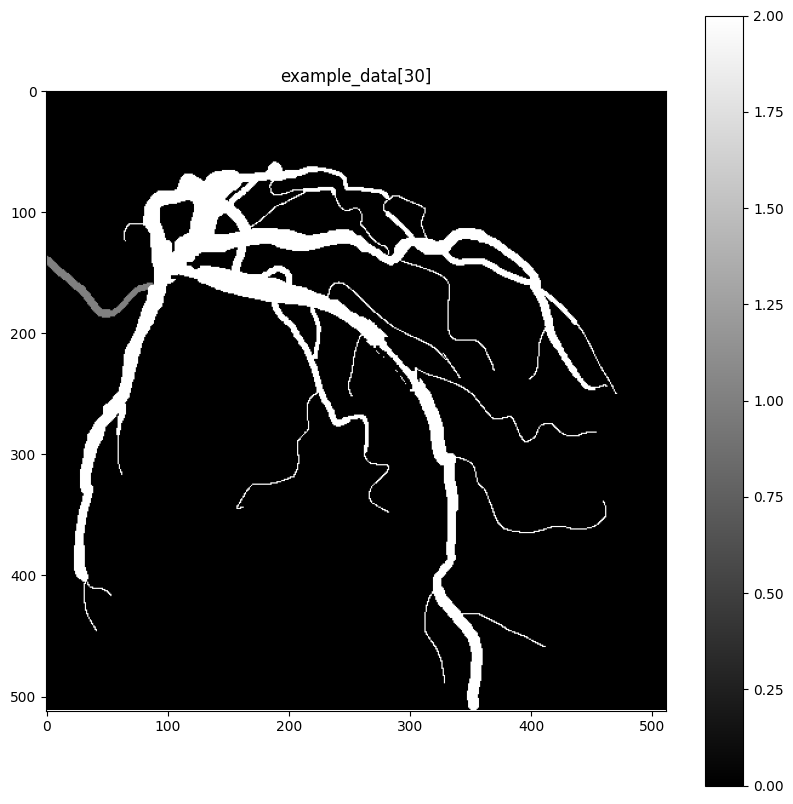

In [9]:
# Display as an image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(example_data[30], cmap='gray')
plt.colorbar()
plt.title('example_data[30]')
plt.axis('on')
plt.show()


In [10]:

def export_annotations_to_nnunet(annotationDataFile, nnUNetRawFolder, frameKeys):
    """
    Modified to only process common keys and verify count matches angiography
    """
    labels_dir = os.path.join(nnUNetRawFolder, 'labelsTr')
    Path(labels_dir).mkdir(parents=True, exist_ok=True)
    
    with h5py.File(annotationDataFile, 'r') as f:
        blockCounter = 0
        
        # Only iterate through common keys
        for dataset_name, center_idx in frameKeys:
            print(f"Processing annotation dataset: {dataset_name}")
            anno_data = f[dataset_name][center_idx]
            
            filename = f'Angios_{blockCounter:04d}.png'
            filepath = os.path.join(labels_dir, filename)
            cv2.imwrite(filepath, anno_data)
                
            blockCounter += 1
        
        print(f"Exported {blockCounter} label files")
        
        # Verify we have the same number of cases as angiography
        assert blockCounter == len(frameKeys), \
            f"Mismatch in number of cases: Angiography had {len(frameKeys)}, Annotations had {blockCounter}"


In [11]:
# Print first 50 frame keys to inspect the data
print("First 50 frame keys:")
for i, (dataset_name, center_idx) in enumerate(frameKeys[:50]):
    print(f"{i}: {dataset_name}, center_idx={center_idx}")


First 50 frame keys:
0: 01_Case_CSF8U1R1_14, center_idx=4
1: 01_Case_CSF8U1R1_14, center_idx=5
2: 01_Case_CSF8U1R1_14, center_idx=6
3: 01_Case_CSF8U1R1_14, center_idx=7
4: 01_Case_CSF8U1R1_14, center_idx=8
5: 01_Case_CSF8U1R1_14, center_idx=9
6: 01_Case_CSF8U1R1_14, center_idx=10
7: 01_Case_CSF8U1R1_14, center_idx=11
8: 01_Case_CSF8U1R1_14, center_idx=12
9: 01_Case_CSF8U1R1_14, center_idx=13
10: 01_Case_CSF8U1R1_14, center_idx=14
11: 01_Case_CSF8U1R1_14, center_idx=15
12: 01_Case_CSF8U1R1_14, center_idx=16
13: 01_Case_CSF8U1R1_14, center_idx=17
14: 01_Case_CSF8U1R1_14, center_idx=18
15: 01_Case_CSF8U1R1_14, center_idx=19
16: 01_Case_CSF8U1R1_14, center_idx=20
17: 01_Case_CSF8U1R1_14, center_idx=21
18: 01_Case_CSF8U1R1_14, center_idx=22
19: 01_Case_CSF8U1R1_14, center_idx=23
20: 01_Case_CSF8U1R1_14, center_idx=24
21: 01_Case_CSF8U1R1_14, center_idx=25
22: 01_Case_CSF8U1R1_14, center_idx=26
23: 01_Case_CSF8U1R1_14, center_idx=27
24: 01_Case_CSF8U1R1_14, center_idx=28
25: 01_Case_CSF8U1R1

In [12]:
export_annotations_to_nnunet(annotationIndicizedDataFile, nnUNetRawFolder, frameKeys)

Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 01_Case_CSF8U1R1_14
Processing annotation dataset: 

In [13]:
len(frameKeys)

7855

In [17]:
# ... existing code ...

from datetime import datetime

# Get current timestamp in a human-readable format
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

datasetJson = {
    "_comment": f"Dataset contains 5-channel angiography data at 7.5Hz (every other frame) with 5-frame neighborhoods. Labels include background (0), C (1), and V (2). Data sourced from WebknossosAngiogramsRevisedUInt8List.h5 and WebknossosAnnotationsRevisedIndicized-3.h5. Generated on {timestamp}.",
    "channel_names": {
        "0": "0",
        "1": "1",
        "2": "2",
        "3": "3",
        "4": "4"
    },
    "labels": {
        "background": 0,
        "catheter": 1,
        "vessel": 2
    },
    "numTraining": len(frameKeys),
    "file_ending": ".png"
}

# Write the dataset.json file
import json
dataset_json_path = os.path.join(nnUNetRawFolder, 'dataset.json')
with open(dataset_json_path, 'w') as f:
    json.dump(datasetJson, f, indent=4)

print(f"Created dataset.json at {dataset_json_path}")

Created dataset.json at /home/ubuntu/nnUNet-Adjustment/data/nnUNet_raw/Dataset632_Angiography/dataset.json


In [16]:
datasetJson

{'_comment': 'Dataset contains 5-channel angiography data at 7.5Hz (every other frame) with 5-frame neighborhoods. Labels include background (0), C (1), and V (2). Data sourced from WebknossosAngiogramsRevisedUInt8List.h5 and WebknossosAnnotationsRevisedIndicized-3.h5. Generated on 2025-04-13 00:39:22.',
 'channel_names': {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'},
 'labels': {'background': 0, 'C': 1, 'V': 2},
 'numTraining': 7855,
 'file_ending': '.png'}